In [1]:
# Load images into image vector matrix - where each row is an image vector
import os

import glob
import cv2
import numpy as np

# Path templates
category_directories_template =  "food_resized/*/[0-9]*_*"
image_files_template = "food_resized/*/*/*.jpg"

#  return cid, name for a given category directory path i.e. 
# 'food_resized/train/0_hot_dog' ---> 0, "hot_dog"
#       use: cid, name = cid_name_from_path(path_string)
def cname_cid_from_path(path_string):
    
    base_dir = None
    if os.path.isfile(path_string):
        base_dir = os.path.basename(os.path.split(path_string)[0])
    elif os.path.isdir(path_string):
        base_dir = os.path.basename(path_string)
    else: 
        raise("Error incorect path")
    
    cid = int(base_dir.split('_')[0]) # get leading number, or cid
    
    idx = base_dir.find('_') + 1      # get trailing string after first '_'
    cname = base_dir[idx:]

    return cname, cid

# {'chicken_wings': 0, 'dumplings': 1, 'hot_dog': 2, 'ramen': 3, 'sushi': 4}
def get_category_cname_cid_map(category_directories_template):
    category_folders = glob.glob(category_directories_template)
    return dict(map(cname_cid_from_path, category_folders))

def image_to_vector(image):
    return image.reshape((1, -1)) / 255

# image_vector of original size 60, 60, 3 back to np image
def image_vector_to_image(image_vector, original_image_size=(60,60,3)):
    image_vector = image_vector * 255
    image_vector = image_vector.astype(int)
    image_vector = image_vector.reshape(original_image_size)
    return image_vector

def get_sample_images_and_labels(images_file_template, gray=False):
    
    image_paths = glob.glob(image_files_template)
    
    images = []
    labels = []
    
    for fname in image_paths:
        
        label, cid = cname_cid_from_path(fname)
        
        img = None
        if gray == True:
            img = cv2.imread(fname,0)
        else:
            img = cv2.imread(fname)
        
            # color stored in incorrect order for plt -> convert to RGB order
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        
        images.append(img)
        labels.append(label)
        
    return images, labels

#load all images into matrix of image vectors, X, and corrresponding vector of categories, y
def get_sample_image_vector_matrix_and_targets(images, labels, cname_cid_dict):
    
    X = image_to_vector(images[0])
    y = []

    for img, l in zip(images, labels):
        
        v = image_to_vector(img) # convert image to vector
        X = np.vstack([X,v])     # add image vector to matrix
        
        y.append(cname_cid_dict[l])
        
    y = np.array(y)
    
    return X,y

#
# load all images into matrix of image vectors, X, and corrresponding vector of categories, y
#

cname_cid_dict = get_category_cname_cid_map(category_directories_template) # get cname:cid dictonary
images, labels = get_sample_images_and_labels(image_files_template, gray=False)

% time X,y = get_sample_image_vector_matrix_and_targets(images, labels, cname_cid_dict)  

# save original shape of images
original_image_shape = images[0].shape

CPU times: user 42.3 s, sys: 48.6 s, total: 1min 30s
Wall time: 1min 43s


In [2]:
# above operation takes a long time save results to files
import pickle
pickle.dump(X, open( 'large_data/X.p', 'wb' ))
pickle.dump(y, open( 'large_data/y.p', 'wb' ))

In [3]:
# load
import pickle
X = pickle.load(open( 'large_data/X.p', 'rb' ))
y = pickle.load(open( 'large_data/y.p', 'rb' ))

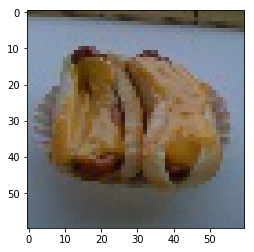

In [6]:
import matplotlib.pyplot as plt

idx = 0
v = X[idx]

image = image_vector_to_image(v, original_image_size=original_image_shape) #reconstruct image from vector
plt.imshow(image)

In [7]:
help(cv2.xfeatures2d.SIFT_create())
help(cv2.xfeatures2d)

Help on xfeatures2d_SIFT object:

class xfeatures2d_SIFT(Feature2D)
 |  Method resolution order:
 |      xfeatures2d_SIFT
 |      Feature2D
 |      Algorithm
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.
 |  
 |  __repr__(self, /)
 |      Return repr(self).
 |  
 |  create(...) from builtins.type
 |      create([, nfeatures[, nOctaveLayers[, contrastThreshold[, edgeThreshold[, sigma]]]]]) -> retval
 |      .   @param nfeatures The number of best features to retain. The features are ranked by their scores
 |      .   (measured in SIFT algorithm as the local contrast)
 |      .   
 |      .   @param nOctaveLayers The number of layers in each octave. 3 is the value used in D. Lowe paper. The
 |      .   number of octaves is computed automatically from the image resolution.
 |      .   
 |      .   @param contrastThreshold The contrast threshold used

In [ ]:
import math
import time

def modified_sigmoid(x, k):
     return 1 / (1 + math.exp(-x/k)) - 0.5

def to_gray(image):
    # converting image to grayscale
    # must save the image again to use cv2.convert color, path must be relative
    local_path = 'tmp.jpg'
    cv2.imwrite(local_path, image)
    img = cv2.imread(local_path)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return gray


def sift_distance(gray1, gray2, original=None):

    img1 = gray1
    img2 = gray2

    # ORB Detector
    #orb = cv2.ORB_create()
    #kp1, des1 = orb.detectAndCompute(img1, None)
    #kp2, des2 = orb.detectAndCompute(img2, None)

    # Brute Force Matching
    #bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    #matches = bf.match(des1, des2)
    #matches = sorted(matches, key = lambda x:x.distance)
    
    # find the keypoints and descriptors with SIFT
    Sift = cv2.xfeatures2d.SIFT_create()
    kp1, des1 = Sift.detectAndCompute(img1,None)
    kp2, des2 = Sift.detectAndCompute(img2,None)
    
    # Brute Force Matching
    bf = cv2.BFMatcher()
    
    matches = bf.knnMatch(des1,des2, k=2)

    #Apply ratio test
    threshold = 0.88
    good_matches = 0
    for m,n in matches:
        if m.distance < threshold * n.distance:
            good_matches += 1

    return modified_sigmoid(good_matches, 5)


# number of images
n = X.shape[0]

# distance matrix
D = np.zeros(shape=(n,n))


start = time.time()
for i in range(n):
    p = i/n
    print("%s percent complete" % p)
    for j in range(n):
        
        idx1= i
        idx2 = j

        im1 = image_vector_to_image(X[idx1])
        im2 = image_vector_to_image(X[idx2])
        gray1 = to_gray(im1)
        gray2 = to_gray(im2)

        sd = sift_distance(gray1, gray2)
        
        D[i,j] = sd
        D[j,i] = sd

        
# set diagnols to zero
np.fill_diagonal(D, 0)
end = time.time()
print("time: %s" % (end - start))

print(D)

# above operation takes a long time save results to files
import pickle
pickle.dump(X, open( 'large_data/D.p', 'wb' ))

0.0 percent complete
0.0005711022272986865 percent complete
0.001142204454597373 percent complete
0.0017133066818960593 percent complete
0.002284408909194746 percent complete
0.0028555111364934323 percent complete
0.0034266133637921186 percent complete
0.003997715591090805 percent complete
0.004568817818389492 percent complete
0.005139920045688178 percent complete
0.0057110222729868645 percent complete
0.006282124500285551 percent complete
0.006853226727584237 percent complete
0.0074243289548829245 percent complete
0.00799543118218161 percent complete
0.008566533409480296 percent complete
0.009137635636778984 percent complete
0.009708737864077669 percent complete
0.010279840091376356 percent complete
0.010850942318675044 percent complete
0.011422044545973729 percent complete
0.011993146773272416 percent complete
0.012564249000571102 percent complete
0.013135351227869789 percent complete
0.013706453455168474 percent complete
0.014277555682467162 percent complete
0.014848657909765849 per

In [ ]:
# load
import pickle
D = pickle.load(open( 'large_data/D.p', 'rb' ))

In [ ]:
# find most similar image 
def find_similar(idx, D, X):
    
    v = X[idx,: ]
    
    #row = D[idx,:]
    row = D[:,idx]
    print(row)
    max_idx = np.argmax(row, axis=0)
    
    v_match = X[max_idx,:]
    
    # convert to images
    im1 = image_vector_to_image(v)
    im2 = image_vector_to_image(v_match)
    
    return im1, im2, max_idx

def display_most_similar_image(selected_index):

    # selecting image index
    idx = selected_index
    im1, im2, midx = find_similar(idx, D, X)

    w=10
    h=10
    fig=plt.figure(figsize=(8, 8))
    columns = 2
    rows = 1

    fig.add_subplot(rows, columns, 1)
    plt.imshow(im1)

    fig.add_subplot(rows, columns, 2)
    plt.imshow(im2)

    plt.show()

    im1_class = cid_cname_dict[y[idx]]
    im2_class = cid_cname_dict[y[midx]]

    print("selected image class: %s, returned image class: %s" % (im1_class, im2_class))


# cid to cname dictonary
cid_cname_dict = {v:k for k,v in cname_cid_dict.items()}

n = X.shape[0]
widgets.interact(display_most_similar_image,selected_index=(0,n-1,1),__manual=True)